In [1]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd
from jnkepler.jaxttv import *
from jnkepler.jaxttv.utils import elements_to_pdic, params_to_elements
from jax.config import config
import numpyro, jax
config.update('jax_enable_x64', True)
numpyro.set_platform('cpu')
num_chains = 1
numpyro.set_host_device_count(num_chains)
print ('# jax device count:', jax.local_device_count())

# jax device count: 1


In [2]:
import seaborn as sns
sns.set(style='ticks', font_scale=1.6, font='times')
plt.rcParams["figure.figsize"] = (12,6)
from matplotlib import rc
rc('text', usetex=True*0)

In [3]:
d = pd.read_csv("kep51/ttv.txt", delim_whitespace=True, header=None, names=['tnum', 'tc', 'tcerr', 'dnum', 'planum'])
tcobs = [jnp.array(d.tc[d.planum==j+1]) for j in range(3)]
errorobs = [jnp.array(d.tcerr[d.planum==j+1]) for j in range(3)]
p_init = [45.155305, 85.31646, 130.17809]

In [4]:
dt = 1.0
t_start, t_end = 155., 2950.
jttv = JaxTTV(t_start, t_end, dt) # jaxttv class

In [5]:
jttv.set_tcobs(tcobs, p_init, errorobs=errorobs, print_info=True)

# integration starts at:           155.00
# first transit time in data:      159.11
# last transit time in data:       2945.75
# integration ends at:             2950.00
# integration time step:           1.0000 (1/45 of innermost period)


In [7]:
import dill

In [11]:
mcmc = dill.load(open('kep51/dt1.0_nw500_ns1500_c4_mcmc.pkl', 'rb'))

In [12]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   cosw[0]     -0.70      0.44     -0.63     -1.34     -0.06    316.17      1.00
   cosw[1]      0.58      0.88      0.60     -0.80      2.15    453.99      1.01
   cosw[2]     -0.01      0.95      0.02     -1.59      1.51    351.95      1.02
    ecc[0]      0.03      0.01      0.03      0.01      0.05    182.81      1.02
    ecc[1]      0.01      0.01      0.01      0.00      0.03     76.33      1.02
    ecc[2]      0.01      0.01      0.01      0.00      0.02     76.59      1.03
   mass[0]      0.00      0.00      0.00      0.00      0.00    478.83      1.00
   mass[1]      0.00      0.00      0.00      0.00      0.00    273.25      1.01
   mass[2]      0.00      0.00      0.00      0.00      0.00    465.92      1.01
 period[0]     45.15      0.00     45.15     45.15     45.15    640.67      1.00
 period[1]     85.31      0.00     85.31     85.31     85.32    485.88      1.00
 period[2]    130.18      0

In [13]:
samples = mcmc.get_samples()

In [14]:
M_earth = 3.0034893e-6
samples['pmass'] = samples['mass'] / M_earth

### TTVFast parameters and models

In [44]:
from jnkepler.jaxttv.ttvfastutils import *
from jnkepler.jaxttv.utils import findidx_map

In [45]:
# dataframe containing parameter sets for TTVFast
pttvfast = params_for_ttvfast(samples, jttv.t_start, jttv.nplanet)

In [46]:
import ttvfast
def get_planets_smass(pdic, num_planets):
    """ set up planets class for ttvfast-python

        Args:
            pdic: parameter dataframe from params_for_ttvfast
            num_planets: number of planets

        Returns:
            list of ttvfast.models.Planet
            stellar mass (solar unit)

    """
    planets = []
    for i in range(num_planets):
        pltag = "%d"%i
        planet_tmp = ttvfast.models.Planet(
            mass=pdic['planet_mass'+pltag],
            period=pdic['period'+pltag],
            eccentricity=pdic['eccentricity'+pltag],
            inclination=pdic['inclination'+pltag],
            longnode=pdic['longnode'+pltag],
            argument=pdic['argument'+pltag],
            mean_anomaly=pdic['mean_anomaly'+pltag]
        )
        planets.append(planet_tmp)

    return planets, float(pdic.star_mass)

In [77]:
sidx = 0

In [82]:
pdic = pttvfast.iloc[sidx]
num_planets = 3

In [88]:
times_rv = np.linspace(t_start+5, t_end-5, 1000)

In [89]:
planets, smass = get_planets_smass(pdic, num_planets)
ttvfast_results = ttvfast.ttvfast(planets, smass, t_start, dt, t_end, rv_times=list(times_rv))

In [90]:
idx_planet = np.array(ttvfast_results['positions'][0],'i')
transit_epochs = np.array(ttvfast_results['positions'][1],'i')
transit_times = np.array(ttvfast_results['positions'][2],'d')
impact_params = np.array(ttvfast_results['positions'][3], 'd')
rvs = np.array(ttvfast_results['rv'], 'd') * 1.495978707e11 / 86400.

In [92]:
_, rvs_jaxttv, _ = jttv.get_ttvs_and_rvs(samples['elements'][sidx], samples['masses'][sidx], times_rv)

/var/folders/68/h6r0kcq50914zzw8n_70l69c0000gn/T/ipykernel_92338/2675863128.py:3: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(times_rv, rvs_jaxttv, '-', lw=1, label='jnkepler', ls='dashed')


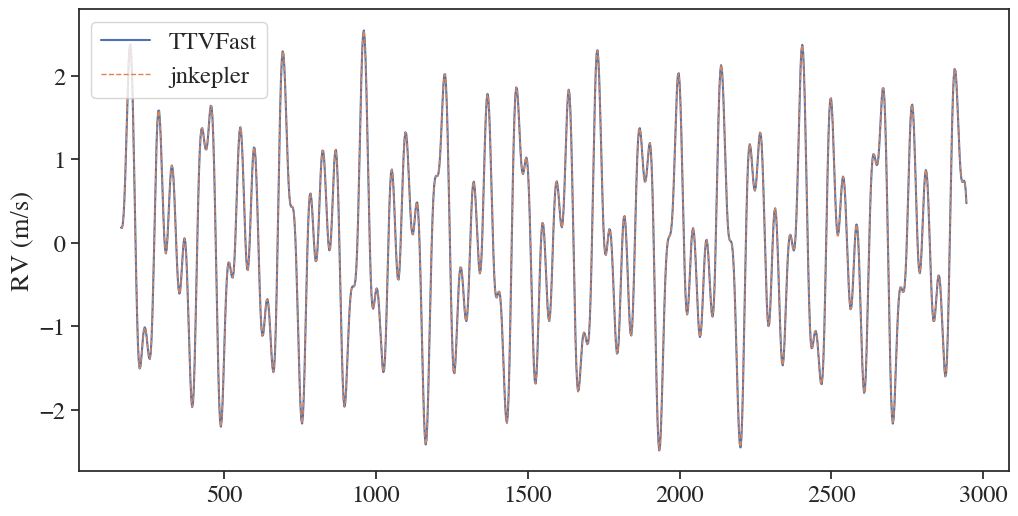

In [100]:
plt.ylabel("RV (m/s)")
plt.plot(times_rv, rvs, '-', label='TTVFast')
plt.plot(times_rv, rvs_jaxttv, '-', lw=1, label='jnkepler', ls='dashed')
plt.legend();

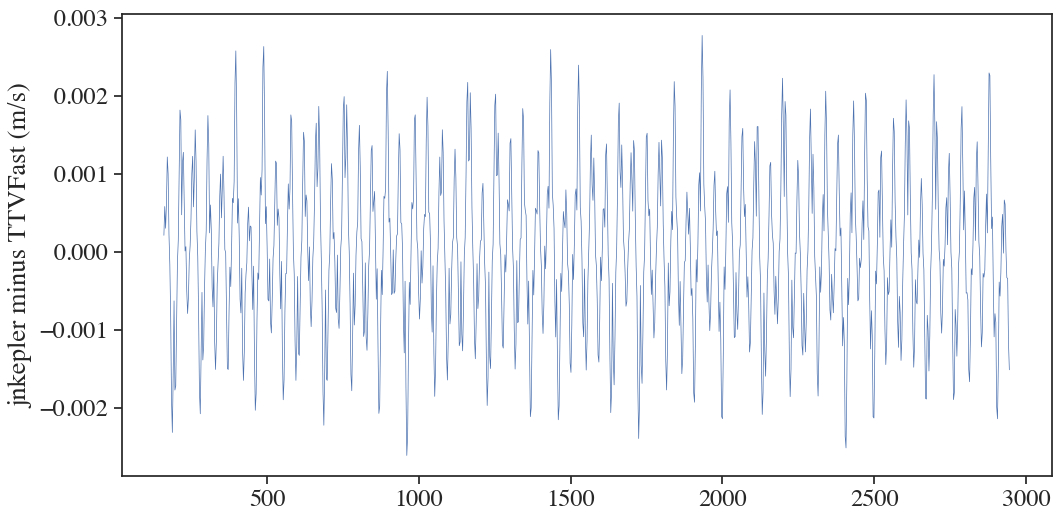

In [99]:
plt.ylabel("jnkepler minus TTVFast (m/s)")
plt.plot(times_rv, rvs_jaxttv-rvs, '-', lw=0.5)